# Running ensembles of SUMMA simulations

`pysumma` offers an `Ensemble` class which is useful for running multiple simulations with varying options. These options can be parameter values, model structures, different locations made up of different file managers, or combinations of any of these. To demonstrate the `Ensemble` capabilities we will step through each individually. As usual we will begin with some imports and definition of some global variables.

In [1]:
import numpy as np
import pysumma as ps
import matplotlib.pyplot as plt
from pprint import pprint

!cd data/reynolds && ./install_local_setup.sh && cd -
!cd data/coldeport && ./install_local_setup.sh && cd -

summa_exe = 'summa.exe'
file_manager = './data/coldeport/file_manager.txt'

/pool0/data/andrbenn/workspace/pysumma-tutorial
/pool0/data/andrbenn/workspace/pysumma-tutorial


## Changing decisions

The `Ensemble` object mainly operates by taking configuration dictionaries. These can be defined manually, or can be defined through the use of helper functions which will be described later. For now, we will look at how to run models using different options for the `stomResist` and `soilStress` decisions. This is done by providing a dictionary of these mappings inside of a `decisions` key of the overall configuration. The `decisions` key is one of several special configuration keys which `pysumma` knows how to manipulate under the hood. We will explore the others later.

This configuration is used to construct the `Ensemble` object, which also takes the SUMMA executable, a file manager path, and optionally the `num_workers` argument. The `num_workers` argument is used to automatically run these ensemble members in parallel. Here we define it as 2, since that's how many different runs we will be completing. You _can_ set this to a higher number than your computer has CPU cores, but you won't likely see any additional speedup by doing so.

We then run the ensemble through the `run` method which works similarly to the `Simulation` object. After running the ensemble we check the status by running the `summary` method. This will return a dictionary outlining any successes or failures of each of the members. In the event of any failures you can later inspect the underlying `Simulation` objects that are internal to the `Ensemble`. We will demonstrate how to do this later in the tutorial.

In [2]:
config = {
    'run0': {'decisions':{'stomResist': 'Jarvis',
                          'soilStress': 'NoahType'}},
    'run1': {'decisions':{'stomResist': 'BallBerry',
                          'soilStress': 'CLM_Type'}},
}

decision_ens = ps.Ensemble(summa_exe, config, file_manager, num_workers=2)
decision_ens.run('local')
print(decision_ens.summary())

/pool0/data/andrbenn/.conda/all/lib/python3.7/site-packages/distributed/node.py:244: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43326 instead
  http_address["port"], self.http_server.port


NameError: name 'decisions_ens' is not defined

We also provide some functionality to make it easier to wrangle the data together via the `merge_output` method.

<br>

To access the simulations individually you can use the `.simulations` attribute, which is simply a dictionary of the `Simulation` objects mapped by the `name` that's used to run the simulation. Let's loop through and print the decisions directly from the `Simulation` as proof things worked. We can also open the output of each of the simulations as in the previous tutorial, and plot the monthly average latent heat flux for each simulation.

In [12]:
for n, sim in decision_ens.simulations.items():
    print(f'{n} used {sim.decisions["stomResist"].value} for the stomResist option and {sim.decisions["soilStress"].value} for soilStress')

run0 used Jarvis for the stomResist option and NoahType for soilStress
run1 used BallBerry for the stomResist option and CLM_Type for soilStress


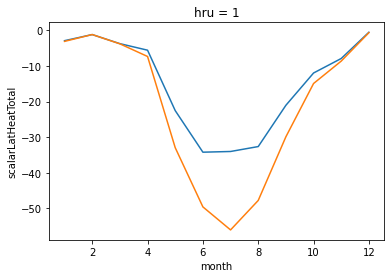

In [17]:
run0 = decision_ens.simulations['run0'].output.load()
run1 = decision_ens.simulations['run1'].output.load()

run0['scalarLatHeatTotal'].groupby(run0['time'].dt.month).mean().plot(label='run0')
run1['scalarLatHeatTotal'].groupby(run1['time'].dt.month).mean().plot(label='run1')

<br>
Note in the previous example we didn't run every combination of `stomResist` and `soilStress` that we could have. When running multiple configurations it often becomes unwieldy to type out the full configuration that you are attempting to run, so some helper functions have been implemented to make this a bit easier. In the following cell we demonstrate this. You can see that the new output will show we have 4 configurations to run, each with a unique set of decisions. The names are just the decisions being set, delimited by `++` so that it is easy to keep track of each run.

In [19]:
decisions_to_run = {
    'stomResist': ['Jarvis', 'BallBerry'],
    'soilStress': ['NoahType', 'CLM_Type']
}

config = ps.ensemble.decision_product(decisions_to_run)
pprint(config)

{'++BallBerry++CLM_Type++': {'decisions': {'soilStress': 'CLM_Type',
                                           'stomResist': 'BallBerry'}},
 '++BallBerry++NoahType++': {'decisions': {'soilStress': 'NoahType',
                                           'stomResist': 'BallBerry'}},
 '++Jarvis++CLM_Type++': {'decisions': {'soilStress': 'CLM_Type',
                                        'stomResist': 'Jarvis'}},
 '++Jarvis++NoahType++': {'decisions': {'soilStress': 'NoahType',
                                        'stomResist': 'Jarvis'}}}


In [20]:
decision_ens = ps.Ensemble(summa_exe, config, file_manager, num_workers=4)
decision_ens.run('local')
print(decision_ens.summary())

{'success': ['++Jarvis++NoahType++', '++Jarvis++CLM_Type++', '++BallBerry++NoahType++', '++BallBerry++CLM_Type++'], 'error': [], 'other': []}


<br>

When ensembles have been run through these `product` configurations (we'll detail a couple others later), you can use a special method to open them in a way that makes the output easier to wrangle. As before we'll plot the mean monthly latent heat for each of the runs.

In [24]:
ens_ds = decision_ens.merge_output()
ens_ds

/pool0/data/andrbenn/workspace/pysumma/pysumma/ensemble.py:127: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  full = xr.open_mfdataset(out_file_paths, concat_dim='run_number')
/pool0/data/andrbenn/.conda/all/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied do not have global dimension coordinates. In
future, to continue concatenating without supplying dimension
coordinates, please use the new `combine_nested` function (or the
`combine='nested'` option to open_mfdataset.
  from_openmfds=True,


<xarray.Dataset>
Dimensions:                (gru: 1, hru: 1, ifcSnow: 6, ifcToto: 15, midToto: 14, soilStress: 2, stomResist: 2, time: 52585)
Coordinates:
  * hru                    (hru) int32 1
  * gru                    (gru) int32 1
  * time                   (time) datetime64[ns] 1994-10-01T00:59:59.999986592 ... 2000-09-30T00:59:59.999986560
  * stomResist             (stomResist) object 'BallBerry' 'Jarvis'
  * soilStress             (soilStress) object 'CLM_Type' 'NoahType'
Dimensions without coordinates: ifcSnow, ifcToto, midToto
Data variables:
    nSnow                  (time, hru, stomResist, soilStress) int32 dask.array<chunksize=(52585, 1, 1, 2), meta=np.ndarray>
    scalarSnowDepth        (time, hru, stomResist, soilStress) float64 dask.array<chunksize=(52585, 1, 1, 2), meta=np.ndarray>
    scalarSWE              (time, hru, stomResist, soilStress) float64 dask.array<chunksize=(52585, 1, 1, 2), meta=np.ndarray>
    mLayerTemp             (time, midToto, hru, stomResist, soilStress) float64 dask.array<chunksize=(52585, 14, 1, 1, 2), meta=np.ndarray>
    mLayerVolFracIce       (time, midToto, hru, stomResist, soilStress) float64 dask.array<chunksize=(52585, 14, 1, 1, 2), meta=np.ndarray>
    mLayerVolFracLiq       (time, midToto, hru, stomResist, soilStress) float64 dask.array<chunksize=(52585, 14, 1, 1, 2), meta=np.ndarray>
    mLayerVolFracWat       (time, midToto, hru, stomResist, soilStress) float64 dask.array<chunksize=(52585, 14, 1, 1, 2), meta=np.ndarray>
    scalarSurfaceTemp      (time, hru, stomResist, soilStress) float64 dask.array<chunksize=(52585, 1, 1, 2), meta=np.ndarray>
    mLayerDepth            (time, midToto, hru, stomResist, soilStress) float64 dask.array<chunksize=(52585, 14, 1, 1, 2), meta=np.ndarray>
    mLayerHeight           (time, midToto, hru, stomResist, soilStress) float64 dask.array<chunksize=(52585, 14, 1, 1, 2), meta=np.ndarray>
    iLayerHeight           (time, ifcToto, hru, stomResist, soilStress) float64 dask.array<chunksize=(52585, 15, 1, 1, 2), meta=np.ndarray>
    scalarSnowfallTemp     (time, hru, stomResist, soilStress) float64 dask.array<chunksize=(52585, 1, 1, 2), meta=np.ndarray>
    scalarSnowAge          (time, hru, stomResist, soilStress) float64 dask.array<chunksize=(52585, 1, 1, 2), meta=np.ndarray>
    scalarTotalSoilLiq     (time, hru, stomResist, soilStress) float64 dask.array<chunksize=(52585, 1, 1, 2), meta=np.ndarray>
    scalarTotalSoilIce     (time, hru, stomResist, soilStress) float64 dask.array<chunksize=(52585, 1, 1, 2), meta=np.ndarray>
    scalarRainfall         (time, hru, stomResist, soilStress) float64 dask.array<chunksize=(52585, 1, 1, 2), meta=np.ndarray>
    scalarSnowfall         (time, hru, stomResist, soilStress) float64 dask.array<chunksize=(52585, 1, 1, 2), meta=np.ndarray>
    scalarSenHeatTotal     (time, hru, stomResist, soilStress) float64 dask.array<chunksize=(52585, 1, 1, 2), meta=np.ndarray>
    scalarLatHeatTotal     (time, hru, stomResist, soilStress) float64 dask.array<chunksize=(52585, 1, 1, 2), meta=np.ndarray>
    scalarSnowSublimation  (time, hru, stomResist, soilStress) float64 dask.array<chunksize=(52585, 1, 1, 2), meta=np.ndarray>
    iLayerConductiveFlux   (time, ifcToto, hru, stomResist, soilStress) float64 dask.array<chunksize=(52585, 15, 1, 1, 2), meta=np.ndarray>
    iLayerAdvectiveFlux    (time, ifcToto, hru, stomResist, soilStress) float64 dask.array<chunksize=(52585, 15, 1, 1, 2), meta=np.ndarray>
    iLayerNrgFlux          (time, ifcToto, hru, stomResist, soilStress) float64 dask.array<chunksize=(52585, 15, 1, 1, 2), meta=np.ndarray>
    mLayerNrgFlux          (time, midToto, hru, stomResist, soilStress) float64 dask.array<chunksize=(52585, 14, 1, 1, 2), meta=np.ndarray>
    scalarSnowDrainage     (time, hru, stomResist, soilStress) float64 dask.array<chunksize=(52585, 1, 1, 2), meta=np.ndarray>
    iLayerLiqFluxSnow      (time, ifcSnow, hru, stomResist, soilStress) float64 dask.array<chunksize=(52585, 6, 1, 1, 2), m

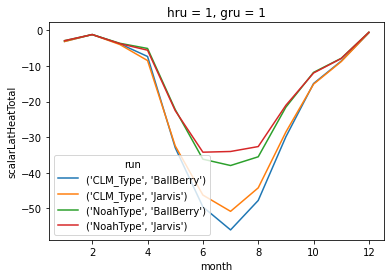

In [28]:
stack = ens_ds.sel(hru=1, gru=1).stack(run=['soilStress', 'stomResist'])
stack['scalarLatHeatTotal'].groupby(stack['time'].dt.month).mean(dim='time').plot.line(x='month')

<br>

## Changing parameters

Similarly, you can change parameter values to do sensitivity experiments:

In [ ]:
config = {
    'run0': {'trial_params': {'windReductionParam': 0.1,
                              'canopyWettingFactor': 0.1}},
    'run1': {'trial_params': {'windReductionParam': 0.9,
                              'canopyWettingFactor': 0.9}}
}

param_ens = ps.Ensemble(summa_exe, config, file_manager, num_workers=2)
param_ens.run('local')
print(param_ens.summary())

<br> 

As you can tell, it can quickly become tiresome to type out every parameter value you want to set. To that end we also have a helper function for setting up these parameter sensitivity experiments. Now you can see that we will end up with 4 configurations, as before. We won't run this because it may take longer than is instructional. But, you can modify this notebook if you wish to see the effect each of these have.

In [ ]:
parameters_to_run = {
    'windReductionParam': [0.1, 0.9],
    'canopyWettingFactor': [0.1, 0.9]
}

config = ps.ensemble.trial_parameter_product(parameters_to_run)
pprint(config)


## Running multiple sites via file managers

As you may have guessed, you can also define an `Ensemble` by providing a list of file managers. This is useful for running multiple sites which can't be collected into a multi HRU run because they have different simulation times, are disjointly located, or for any other reason. It is important to note that in this case we don't provide the `Ensemble` constructor a `file_manager` argument, as it is now provided in the configuration.

In [ ]:
config = {
    'run0': {'file_manager': './data/coldeport/file_manager.txt'},
    'run1': {'file_manager': './data/reynolds/file_manager.txt'},
}

manager_ens = ps.Ensemble(summa_exe, config, num_workers=2)
manager_ens.run('local')
print(manager_ens.summary())

In [ ]:
managers_to_run = {
    'file_manager': ['./data/coldeport/file_manager.txt', './data/coldeport/file_manager.txt']
}

config = ps.ensemble.file_manager_product(managers_to_run)
pprint(config)


## Combining ensemble types

Each of these abilities are useful in their own right, but the ability to combine them into greater ensembles provides a very flexible way to explore multiple hypotheses. To this end we also provide a helper function which can facilitate running these larger experiments. We won't print out the entire configuration here, since it's quite long. Instead we show that this would result in 32 SUMMA simulations. For that reason we also won't run this experment by default, though you can if you wish to.

In [ ]:
config = ps.ensemble.total_product(dec_conf=decisions_to_run, 
                                   param_trial_conf=parameters_to_run, 
                                   fman_conf=managers_to_run)
print(len(config))

For illustrative purpose we show the first key of this configuration

In [ ]:
print(list(config.keys())[0])

<br>

As you can see, the keys (or names of the runs) grows when you include more options. This can be a problem for some operating systems/filesystems, along with being very hard to read. So, we also have a flag here that makes things more compact

In [ ]:
config = ps.ensemble.total_product(dec_conf=decisions_to_run, 
                                   param_trial_conf=parameters_to_run, 
                                   fman_conf=managers_to_run,
                                   sequential_keys=True
                                  )
print(list(config.keys())[0])